In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))  # setup đường dẫn

import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Models

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Metrics
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    ConfusionMatrixDisplay
)

In [2]:
input_path = "../data/processed/Global_Landslide_Processed.csv"
df = pd.read_csv(input_path)
df.head()

,source_name,event_id,event_date,event_title,location_accuracy,landslide_category,landslide_trigger,landslide_size,landslide_setting,fatality_count,injury_count,country_name,admin_division_name,admin_division_population,gazeteer_closest_point,gazeteer_distance,longitude,latitude,year,month
0,AGU,684,2008-08-01 00:00:00,"Sigou Village, Loufan County, Shanxi Province",unknown,landslide,rain,large,mine,11.0,NaN,China,Shaanxi,0.0,Jingyang,41.02145,107.4500,32.5625,2008,8
1,Oregonian,956,2009-01-02 02:00:00,"Lake Oswego, Oregon",5km,mudslide,downpour,small,unknown,0.0,NaN,United States,Oregon,36619.0,Lake Oswego,0.60342,-122.6630,45.4200,2009,1
2,CBS News,973,2007-01-19 00:00:00,"San Ramon district, 195 miles northeast of the...",10km,landslide,downpour,large,unknown,10.0,NaN,Peru,Junín,14708.0,San Ramón,0.85548,-75.3587,-11.1295,2007,1
3,Reuters,1067,2009-07-31 00:00:00,Dailekh district,unknown,landslide,monsoon,medium,unknown,1.0,NaN,Nepal,Mid Western,20908.0,Dailekh,0.75395,81.7080,28.8378,2009,7
4,The Freeman,2603,2010-10-16 12:00:00,sitio Bakilid in barangay Lahug,5km,landslide,tropical_cyclone,medium,unknown,0.0,NaN,Philippines,Central Visayas,798634.0,Cebu City,2.02204,123.8978,10.3336,2010,10


**Câu hỏi 3: Trong các đơn vị hành chính có dân số cao, những tháng nào ghi nhận nhiều vụ sạt lở nhất và các vụ sạt lở trong những tháng này gây ra mức độ thiệt hại về con người (tử vong và bị thương) ra sao?**

### Tiền xử lý
Các cột cần xử lý là: `fatality_count, injury_count, admin_division_population`  
**Các bước xử lý:**
1. Điền giá trị 0 vào các giá trị thiếu của các cột `fatality_count, injury_count`.
2. Loại bỏ các dòng thiếu thông tin quan trọng và có giá trị bằng 0 của cột `admin_division_population`.
3. Lọc khu vực có dân số cao (Top 25%), lấy lớn hơn tứ phân vị thứ 3.

In [4]:
# --- Xử lý Missing Values cho thương vong (NaN -> 0) ---
cols_impact = ['fatality_count', 'injury_count']
df[cols_impact] = df[cols_impact].fillna(0)

# --- Loại bỏ các dòng thiếu thông tin quan trọng ---
df_clean = df.dropna(subset=['admin_division_population'])
df_clean = df_clean[df_clean['admin_division_population'] > 0]
print("Số dòng còn lại của bộ dữ liệu sau khi loại bỏ là:", df_clean.shape[0])

Số dòng còn lại của bộ dữ liệu sau khi loại bỏ là: 8303


In [5]:
# --- Lọc khu vực "Dân số cao" ---
# Tính ngưỡng dân số (Top 25% cao nhất)
pop_threshold = df_clean['admin_division_population'].quantile(0.75)
print(f"Dân số cao sẽ có số lượng lớn hơn {pop_threshold} người")
# Lọc dữ liệu
df_high_pop = df_clean[df_clean['admin_division_population'] >= pop_threshold].copy()
print(f"Số lượng bản ghi sau khi lọc: {len(df_high_pop)}")

print(df_high_pop[['admin_division_name','admin_division_population',
                 'month','fatality_count','injury_count']].head())

Dân số cao sẽ có số lượng lớn hơn 44632.0 người
Số lượng bản ghi sau khi lọc: 2094
   admin_division_name  admin_division_population  month  fatality_count  \
4      Central Visayas                   798634.0     10             0.0   
10              Yunnan                  1023674.0     11             4.0   
15              Oregon                   583776.0      1             0.0   
24               Jijel                   148000.0      1             6.0   
26             Sarawak                   570407.0      1             0.0   

    injury_count  
4            0.0  
10           0.0  
15           0.0  
24           0.0  
26           0.0  


### Phân tích
Sử dụng phương pháp phân tích tổng hợp để xét mối quan hệ giữa thời (Tháng) và hậu quả (Thương vong)
Các bước thực hiện:
1. Nhóm dữ liệu đã lọc theo tháng
2. Tính toán các chỉ số thống kê:
   * Đếm số lượng dòng trong mỗi tháng, để biết tháng nào xảy ra nhiều vụ nhất
   * Tính tổng của từng cột `fatality_count` và `injury_count`cho mỗi tháng, để biết tháng nào gây thiệt hại về người lớn nhất
   * Tạo thêm cột `total_casualties = fatality_count + injury_count`
3. Trực quan hóa thông qua các biểu đồ sau:
   * Biểu đồ 1 (Bar Chart): Số vụ theo tháng. Trả lời trực tiếp vế "những tháng nào ghi nhận nhiều vụ sạt lở nhất".
   * Biểu đồ 2 (Bar Chart): Tổng thương vong. Trả lời vế "mức độ thiệt hại về con người".
   * Biểu đồ 3 (Stacked Bar Chart):Tử vong với Bị thương. Làm rõ thêm cấu trúc của thiệt hại (chết hay bị thương), giúp câu trả lời sâu sắc hơn.

Kết quả mong đợi:
- Những tháng có số lượng vụ sạt lở cao thì cũng đồng nghĩa với thiệt hại về người cũng cao hay không?
- Biết được tháng nào nguy hiểm nhất để đưa ra giải pháp phòng tránh
- Biết được khu vực của các quốc gia nào nguy hiểm

In [6]:
# Gom nhóm theo tháng và tính tất cả các chỉ số trong 1 lần
monthly_stats = df_high_pop.groupby('month').agg({
    'event_date': 'count',          # Đếm số vụ sạt lở
    'fatality_count': 'sum',        # Tổng số tử vong
    'injury_count': 'sum'           # Tổng số bị thương
}).rename(columns={'event_date': 'landslide_count'})

# Tính toán cột tổng thương vong (thay thế sum_human_casualty)
monthly_stats['total_casualties'] = (
    monthly_stats['fatality_count'] + monthly_stats['injury_count']
)

# Reset index để đưa 'month' thành cột dữ liệu cho Seaborn dùng
monthly_stats = monthly_stats.reset_index()

### Kết quả và diễn giải

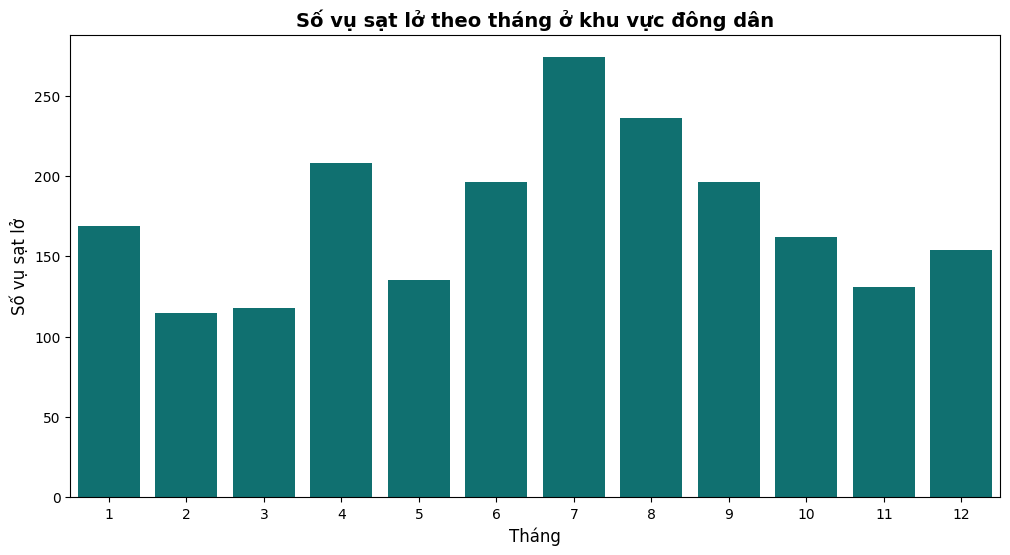

In [11]:
plt.figure(figsize=(12,6))

# --- Biểu đồ 1: Số vụ sạt lở theo tháng ở khu vực đông dân ---
sns.barplot(data=monthly_stats, x='month', y='landslide_count', 
            color='teal')
plt.title("Số vụ sạt lở theo tháng ở khu vực đông dân", fontsize=14, fontweight='bold')
plt.xlabel("Tháng", fontsize=12)
plt.ylabel("Số vụ sạt lở", fontsize=12)

plt.show()

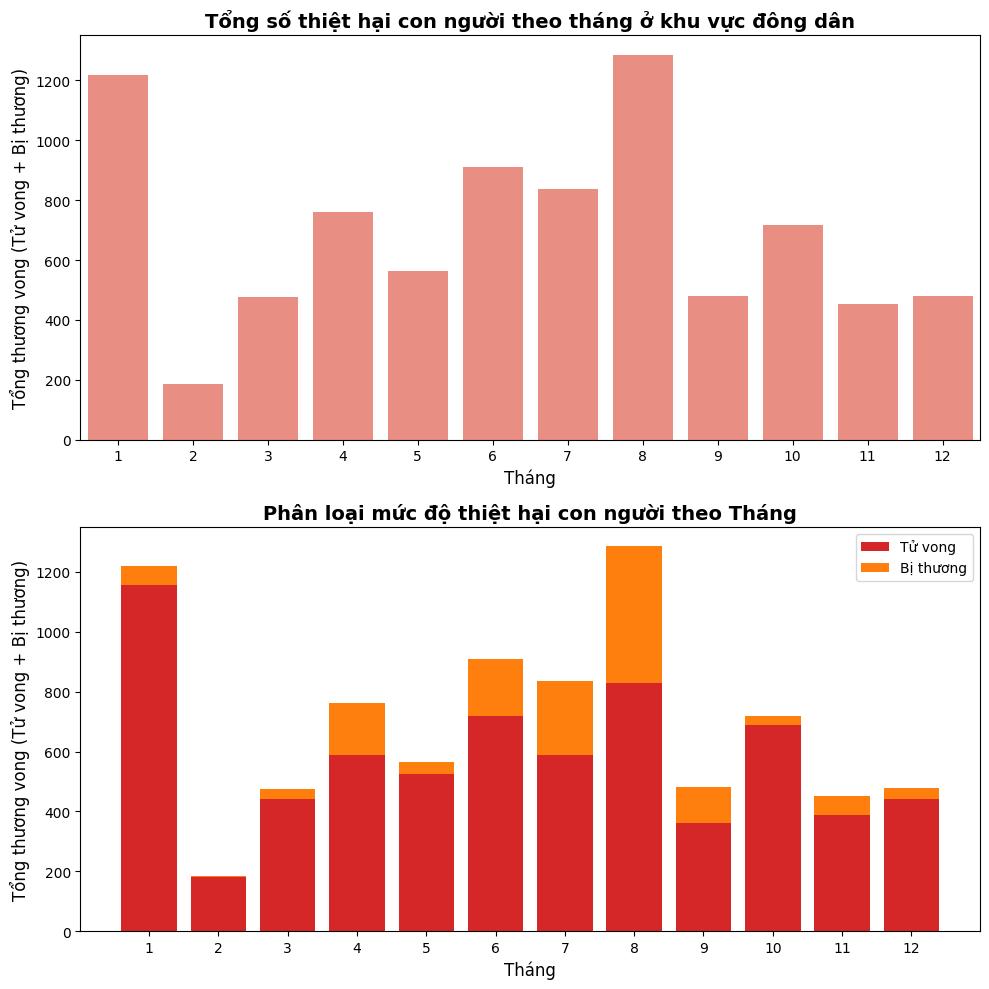

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

# --- Biểu đồ 2: Tổng thương vong theo tháng ---
sns.barplot(data=monthly_stats, x='month', y='total_casualties', 
            color='salmon', ax=axes[0])
axes[0].set_title("Tổng số thiệt hại con người theo tháng ở khu vực đông dân", fontsize=14, fontweight='bold')
axes[0].set_xlabel("Tháng", fontsize=12)
axes[0].set_ylabel("Tổng thương vong (Tử vong + Bị thương)", fontsize=12)

# --- Biểu đồ 3: Tử vong với bị thương theo tháng ---
# Vẽ biểu đồ chồng (Stacked Bar)
# Vẽ cột Tử vong (Nền dưới)
axes[1].bar(monthly_stats['month'], monthly_stats['fatality_count'], color='#d62728', label='Tử vong')

# Vẽ cột Bị thương (Chồng lên trên cột Tử vong - dùng tham số bottom)
axes[1].bar(monthly_stats['month'], monthly_stats['injury_count'], 
             bottom=monthly_stats['fatality_count'], 
             color='#ff7f0e', label='Bị thương')

axes[1].set_title('Phân loại mức độ thiệt hại con người theo Tháng', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Tháng', fontsize=12)
axes[1].set_ylabel('Tổng thương vong (Tử vong + Bị thương)', fontsize=12)
axes[1].set_xticks(monthly_stats['month'])
axes[1].legend()

# Tinh chỉnh khoảng cách giữa các biểu đồ
plt.tight_layout()
plt.show()

**Câu hỏi 4: Dựa trên các đặc điểm về nguyên nhân kích hoạt, thời gian, và bối cảnh địa lý của các vụ sạt lở, có thể xây dựng mô hình học máy để phân loại và cảnh báo sớm xem một vụ sạt lở có khả năng gây thương vong cho con người (tử vong hoặc bị thương) hay không?**

**Động lực và lợi ích:**
- Câu hỏi này đáng để điều tra vì trong quản lý thiên tai, ưu tiên hàng đầu là bảo vệ tính mạng con người. Việc biết chính xác số người chết đôi khi không quan trọng bằng việc biết ngay lập tức liệu sự kiện đó có "nguy hiểm tính mạng" hay không để kích hoạt báo động khẩn cấp.
- Trả lời câu hỏi này sẽ mang lại lợi ích: Giúp lọc nhiễu. Có hàng ngàn vụ sạt lở nhỏ xảy ra mỗi năm không gây hại. Mô hình này giúp loại bỏ các cảnh báo về các vụ sạt lở vô hại, tập trung nguồn lực vào các vụ có ảnh hưởng nguy hiểm đến con người.
- Vấn đề thực tế:
    + Ví dụ: Hệ thống cảnh báo sớm: "Cảnh báo! Vụ sạt lở do mưa lớn tại khu vực dân cư X có 90% xác suất gây thương vong. Yêu cầu sơ tán ngay lập tức."

**Thiết lập bài toán học máy**:
- Loại bài toán: Phân loại nhị phân (Binary Classification).
- Chia tập dữ liệu: bộ dữ liệu sẽ được thành tập train và tập test dựa vào năm sự kiện sạt lở đó xảy ra
    + Tập train: Lấy các sự kiện có năm nhỏ hơn 2016.
    + Tập test: Lấy các sự kiện có năm lớn hơn 2016.
- Các mô hình được xây dựng:
    + Logistic Regression: được sử dụng để dự đoán xác suất xảy ra của một sự kiện thông qua ngưỡng  (ví dụ: Có thương vong hay Không). Mô hình cơ sở để bắt đầu mọi bài toán phân loại.
    + Random Forest Classifier: Sử dụng nhiều cây quyết định, từng cây sẽ có dự đoán riêng. Kết quả cuối cùng được chọn theo nguyên tắc đa số. Xử lý phi tuyến tính: Sạt lở đất là hiện tượng phức tạp không phải lúc nào cũng là đường thẳng.

**Triển khai:**
- Danh sách các đặc trưng (Biến đầu vào) đưa vào mô hình để dự đoán kết quả:
    + landslide_size (Quy mô)
    + landslide_trigger (Nguyên nhân)
    + landslide_setting (Bối cảnh)
    + admin_division_population (Dân số)
    + landslide_category (Loại hình)
    + month (Thời gian - Yếu tố mùa vụ)
    + country_name (Lấy top 10 quốc gia có nhiều vụ sạt lở nhất)
- Biến đầu ra: tạo đặc trưng human_casualty (thiệt hại về người) từ fatality_count và injury_count 

In [8]:


# Tạo target: Human Casualty (0 hoặc 1)
df['human_casualty'] = ((df['fatality_count'] > 0) | (df['injury_count'] > 0)).astype(int)
df.human_casualty.value_counts()

human_casualty
0    8429
1    2604
Name: count, dtype: int64

MÃ HÓA (ENCODING)

In [9]:
# ---------------------------------------------------------
# MÃ HÓA (ENCODING)
# ---------------------------------------------------------
# A. Ordinal Encoding cho landslide_size (Quy ước thủ công)
size_mapping = {
    'small': 1, 
    'medium': 2,
    'large': 3,
    'very_large': 4, 'catastrophic': 4,
    'nan': 2, 'unknown': 2 # Xử lý các giá trị lạ/thiếu bằng mức trung bình
}
# Map vào dữ liệu, những cái không có trong từ điển sẽ thành NaN -> điền là 2
df['landslide_size_encoded'] = df['landslide_size'].map(size_mapping).fillna(2)

# B. Gom nhóm Country (Giữ Top 10 nước, còn lại là 'Other')
top_countries = df['country_name'].value_counts().nlargest(10).index
df['country_group'] = df['country_name'].apply(lambda x: x if x in top_countries else 'Other')


cols_to_use = ['landslide_size_encoded', 'admin_division_population', 'month',
               'landslide_trigger', 'landslide_setting', 'landslide_category', 'country_group', 'year']

# Tạo X (Features) bằng cách One-Hot Encoding (tự động biến đổi các cột chữ)
df_encoded = pd.get_dummies(df[cols_to_use], columns=['landslide_trigger', 'landslide_setting',
                                             'landslide_category', 'country_group'], drop_first=True)
y = df['human_casualty']

KeyError: "['month', 'year'] not in index"

CHIA TẬP TRAIN / TEST

In [ ]:
# ---------------------------------------------------------
# CHIA TẬP TRAIN / TEST
# ---------------------------------------------------------
# Tách tập Train (Năm < 2016)
X_train = df_encoded[df_encoded['year'] < 2016].copy()
y_train = y[df_encoded['year'] < 2016]

# Tách tập Test (Năm >= 2016)
X_test = df_encoded[df_encoded['year'] >= 2016].copy()
y_test = y[df_encoded['year'] >= 2016]

X_train = X_train.drop(columns=['year'])
X_test = X_test.drop(columns=['year'])

CHUẨN HÓA (SCALING) cho biến 'admin_division_population'

In [ ]:
# ---------------------------------------------------------
# CHUẨN HÓA (SCALING)
# ---------------------------------------------------------
scaler = StandardScaler()
# Chỉ fit trên tập train để tránh lộ thông tin sang tập test
X_train[['admin_division_population']] = scaler.fit_transform(X_train[['admin_division_population']])
X_test[['admin_division_population']] = scaler.transform(X_test[['admin_division_population']])

In [ ]:
# ---------------------------------------------------------
# 5. KIỂM TRA KẾT QUẢ
# ---------------------------------------------------------
print("Kích thước tập huấn luyện:", X_train.shape)
print(f"Số lượng mẫu tập Train (< 2016): {len(X_train)} ({len(X_train)/len(df):.1%})")
print(f"Số lượng mẫu tập Test (>= 2016): {len(X_test)} ({len(X_test)/len(df):.1%})")
print("-" * 30)
print(f"Tỷ lệ thương vong trong quá khứ (Train): {y_train.mean():.2%}")
print(f"Tỷ lệ thương vong trong tương lai (Test): {y_test.mean():.2%}")

1. HUẤN LUYỆN MÔ HÌNH 1: LOGISTIC REGRESSION

In [ ]:
print("Đang huấn luyện Logistic Regression...")
# class_weight='balanced': Giúp mô hình chú ý hơn, quan tâm hơn vào lớp thiểu số (Có thương vong)
log_reg = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
log_reg.fit(X_train, y_train)

# Dự đoán
y_pred_log = log_reg.predict(X_test)
y_prob_log = log_reg.predict_proba(X_test)[:, 1]

2. HUẤN LUYỆN MÔ HÌNH 2: RANDOM FOREST

In [ ]:
print("Đang huấn luyện Random Forest...")
# n_estimators=100: Số cây trong rừng
rf_model = RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced')
rf_model.fit(X_train, y_train)

# Dự đoán
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

ĐÁNH GIÁ VÀ SO SÁNH MÔ HÌNH

In [ ]:
# ---------------------------------------------------------
# 3. ĐÁNH GIÁ VÀ SO SÁNH (PHẦN QUAN TRỌNG NHẤT)
# ---------------------------------------------------------
print("\n--- KẾT QUẢ LOGISTIC REGRESSION ---")
print(classification_report(y_test, y_pred_log))
print(f"ROC-AUC: {roc_auc_score(y_test, y_prob_log):.2f}")

print("\n--- KẾT QUẢ RANDOM FOREST ---")
print(classification_report(y_test, y_pred_rf))
print(f"ROC-AUC: {roc_auc_score(y_test, y_prob_rf):.2f}")

Recall (độ nhạy)
- Logistic Regression (0.54): Trong 100 vụ sạt lở chết người thực tế, mô hình phát hiện được 54 vụ.
- Random Forest (0.29): Trong 100 vụ sạt lở chết người thực tế, mô hình chỉ phát hiện được 29 vụ. Nó bỏ sót tới 71 vụ.
-> Random Forest bỏ sót quá nhiều mối nguy hiểm.
ROC-AUC: Đo khả năng phân tách giữa lớp 0 và 1 của mô hình. ROC-AUC đánh giá mô hình ở mọi ngưỡng cắt
- Logistic Regression (0.81): Mức điểm Tốt (>0.8)
- Random Forest (0.78): Mức điểm Khá (<0.8).
Precision (Độ tin cậy)
- Logistic Regression (0.49): Khi nó báo động, chỉ có 49% là thật, 51% là báo động giả.
- Random Forest (0.56): Khi nó báo động, 56% là thật.

Vẽ ROC Curve

In [ ]:
fpr_log, tpr_log, _ = roc_curve(y_test, y_prob_log)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

plt.figure(figsize=(7,6))
plt.plot(fpr_log, tpr_log, label='Logistic')
plt.plot(fpr_rf, tpr_rf, label='Random Forest')
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Human Casualty Prediction")
plt.legend()
plt.show()


-> Là đường cong biểu diễn mối tương quan. Mô hình LOGISTIC REGRESSION tốt hơn 

Confusion Matrix

In [ ]:
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_rf, cmap='Blues'
)
plt.title("Confusion Matrix – Random Forest")
plt.show()


Feature Importance (Diễn giải)

In [ ]:
importances = rf_model.feature_importances_
features = X_train.columns

fi = pd.Series(importances, index=features).sort_values(ascending=False).head(10)
print(fi)